In [1]:
import pandas as pd
import numpy as np
import bootcampviztools as bt
import matplotlib.pyplot as plt
import seaborn as sns
import TeamChallenge_ML_completo as tc

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import catboost


import warnings

# Suprime todos los warnings
warnings.filterwarnings("ignore")

sample = pd.read_csv("data/sample_submission.csv")
import urllib.request
from PIL import Image
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Iván y Manuel: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `laptops_test.csv`. Lloramos.")

In [2]:
train = pd.read_csv("./data/train.csv")
train.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
0,755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
1,618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
2,909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
3,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
4,286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


In [3]:
test = pd.read_csv("./data/test.csv")

In [4]:
train.drop(columns=["Product"], inplace=True)
test.drop(columns=["Product"], inplace=True)

In [5]:
train["ram_gb"] =  train["Ram"].str.replace("GB", "").astype(int)
train["weight_kg"]= train["Weight"].str.replace("kg", "").astype(float)

test["ram_gb"] =  test["Ram"].str.replace("GB", "").astype(int)
test["weight_kg"]= test["Weight"].str.replace("kg", "").astype(float)

train.drop(columns=["Ram", "Weight"], inplace=True)
test.drop(columns=["Ram", "Weight"], inplace=True)

In [6]:
target = "Price_in_euros"

X_train = train.drop(columns=[target])
y_train = train[target].copy()

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         912 non-null    int64  
 1   Company           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Memory            912 non-null    object 
 7   Gpu               912 non-null    object 
 8   OpSys             912 non-null    object 
 9   ram_gb            912 non-null    int32  
 10  weight_kg         912 non-null    float64
dtypes: float64(2), int32(1), int64(1), object(7)
memory usage: 74.9+ KB


In [9]:
num_col = ["Inches", "ram_gb", "weight_kg"]

array([[<Axes: title={'center': 'Inches'}>,
        <Axes: title={'center': 'ram_gb'}>],
       [<Axes: title={'center': 'weight_kg'}>, <Axes: >]], dtype=object)

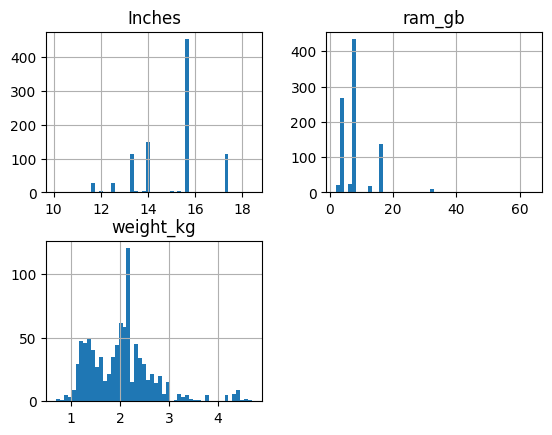

In [10]:
train[num_col].hist(bins=50)

In [11]:
X_train[num_col] = np.log(X_train[num_col])
test[num_col] = np.log(X_train[num_col])

In [12]:
scaler = StandardScaler()

X_train[num_col] = scaler.fit_transform(X_train[num_col])
test[num_col] = scaler.fit_transform(test[num_col])

In [13]:
cat_col = []
for col in X_train.columns:
    if col not in num_col:
        cat_col.append(col)

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         912 non-null    int64  
 1   Company           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Memory            912 non-null    object 
 7   Gpu               912 non-null    object 
 8   OpSys             912 non-null    object 
 9   ram_gb            912 non-null    float64
 10  weight_kg         912 non-null    float64
dtypes: float64(3), int64(1), object(7)
memory usage: 78.5+ KB


In [15]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_col)

cb = CatBoostRegressor(n_estimators=200,
                      loss_function='RMSE',
                       learning_rate=0.4,
                       random_state=1,
                       verbose = False
                      )

cb.fit(train_pool)

In [16]:
pred = cb.predict(test)

In [17]:
pred

array([1515.88894261,  700.19882559,  391.05924485, 1519.64585046,
        645.63599356,  615.61452488,  961.48905222,  980.52773641,
       1039.76549277,  931.01178092, 1595.03018107,  912.11566726,
        339.50072624, 1932.61207698,  968.59388762,  812.76540942,
       2545.73295977, 1721.5090833 , 1680.85742903,  973.29219481,
       1556.08225225, 1040.43638667,  906.13548959,  977.44326187,
        449.50591056, 1003.94355715,  493.11583263,  796.9894629 ,
       1030.33996012, 1137.56170208, 2075.36871655,  507.88372451,
        734.08807778, 1434.43070476, 1341.9921311 , 1269.43871579,
        628.06330629, 1270.75163225, 1350.50283514,  998.63169024,
       1069.43904523,  856.92317578,  828.24515859, 1462.19244234,
        884.80787103, 1137.37028874,  837.65752535,  790.62646219,
       1196.01254816,  901.60999966, 1066.79180752, 1019.46915553,
       1571.1935538 ,  520.80021971, 1859.51473613, 1501.9299614 ,
       1096.53004727,  803.42388144,  739.09021715,  811.64865

In [20]:
test

,laptop_ID,Company,TypeName,Inches,ScreenResolution,Cpu,Memory,Gpu,OpSys,ram_gb,weight_kg
0,209,Lenovo,Gaming,0.557584,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,512GB SSD,Nvidia GeForce GTX 1060,No OS,0.334926,0.188615
1,1281,Acer,Notebook,0.557584,1366x768,Intel Celeron Dual Core N3060 1.6GHz,500GB HDD,Intel HD Graphics 400,Linux,1.337305,0.877936
2,1168,Lenovo,Notebook,0.557584,1366x768,Intel Core i3 6006U 2.0GHz,1TB HDD,Intel HD Graphics 520,No OS,0.334926,0.412332
3,1231,Dell,2 in 1 Convertible,-1.075177,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,256GB SSD,Intel HD Graphics 620,Windows 10,0.334926,-1.023147
4,1020,HP,Notebook,0.557584,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,256GB SSD,Intel HD Graphics 620,Windows 10,-1.077846,0.619941
...,...,...,...,...,...,...,...,...,...,...,...
386,820,MSI,Gaming,-2.557316,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,-1.077846,-1.581395
387,948,Toshiba,Notebook,0.557584,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,128GB SSD,Intel HD Graphics 520,Windows 10,-1.077846,0.574631
388,483,Dell,Workstation,0.557584,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,256GB SSD,Nvidia Quadro M1200,Windows 10,1.337305,1.004882
389,1017,HP,Notebook,-1.075177,1366x768,Intel Core i5 7200U 2.5GHz,500GB HDD,Intel HD Graphics 620,Windows 10,-1.077846,-1.786173


In [21]:
submission = pd.DataFrame({"laptop_ID": test["laptop_ID"], "Price_in_euros": pred})

In [22]:
submission

,laptop_ID,Price_in_euros
0,209,1515.888943
1,1281,700.198826
2,1168,391.059245
3,1231,1519.645850
4,1020,645.635994
...,...,...
386,820,1815.580642
387,948,801.494840
388,483,1916.245296
389,1017,1237.242892


In [23]:
chequeador(submission)

You're ready to submit!


In [24]:
X_train

,laptop_ID,Company,TypeName,Inches,ScreenResolution,Cpu,Memory,Gpu,OpSys,ram_gb,weight_kg
0,755,HP,Notebook,0.457649,Full HD 1920x1080,Intel Core i3 6006U 2GHz,256GB SSD,Intel HD Graphics 520,Windows 10,0.210530,-0.111884
1,618,Dell,Gaming,0.457649,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,1.532306,0.931939
2,909,HP,Notebook,0.457649,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,1TB HDD,Nvidia GeForce 930MX,Windows 10,0.210530,0.179348
3,2,Apple,Ultrabook,-1.156372,1440x900,Intel Core i5 1.8GHz,128GB Flash Storage,Intel HD Graphics 6000,macOS,0.210530,-1.145698
4,286,Dell,Notebook,0.457649,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,1TB HDD,AMD Radeon R5 M430,Linux,-1.111246,0.488257
...,...,...,...,...,...,...,...,...,...,...,...
907,28,Dell,Notebook,0.457649,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,256GB SSD,AMD Radeon 530,Windows 10,0.210530,0.417406
908,1160,HP,2 in 1 Convertible,-1.156372,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,256GB SSD,Intel HD Graphics 520,Windows 10,0.210530,-0.832400
909,78,Lenovo,Notebook,0.457649,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,2TB HDD,Intel HD Graphics 620,No OS,0.210530,0.417406
910,23,HP,Notebook,0.457649,1366x768,AMD E-Series E2-9000e 1.5GHz,500GB HDD,AMD Radeon R2,No OS,-1.111246,-0.111884
